In [1]:
# import machine learning and data science libarires
import math
import pandas as pd
import numpy as np

# import Google Finanace API libraries
from googlefinance.client import get_price_data

# import data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# import other libraries
import datetime as dt
import time

In [2]:
## set the benchmarl dates
#strt_date = '1995-01-01'
#end_date = '2015-06-18'

# set all the tickers
# choose between: 'AAPL', 'MSFT', AMZN'
my_ticker = 'AAPL'

# set all the parameters
my_params = {
'q': my_ticker,    #stock symbol (ex: "AAPL")
'i': "86400",      #interval size in seconds ("86400" = 1 day intervals)
'x': "INDEXNASD",  #stock exchange symbol on which stock is traded (ex: "NASD")
'p': "15Y"          #period (ex: "1Y" = 1 year)
}

# build the dataframe of the stock data
my_stck = get_price_data(my_params)

# reset the indexes
my_stck = my_stck.reset_index()

# print the head of my dataframe
print(my_stck.head())

                index    Open    High     Low   Close     Volume
0 2002-10-07 16:00:00  0.9979  1.0150  0.9829  0.9836   57927800
1 2002-10-08 16:00:00  0.9929  0.9971  0.9543  0.9777  111102600
2 2002-10-09 16:00:00  0.9671  0.9893  0.9579  0.9714   88271400
3 2002-10-10 16:00:00  0.9736  1.0157  0.9700  1.0085   78624000
4 2002-10-11 16:00:00  1.0179  1.0557  1.0071  1.0364   70177800


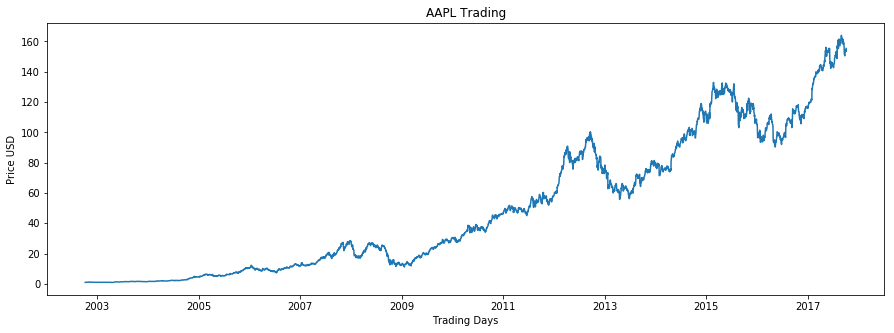

In [3]:
# plot data
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(my_stck['index'], my_stck['Close'])

# format the y-coord label
price = lambda y : '$%1.2f' % y
ax.format_ydata = price

# format the x-coord label
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title(my_ticker + ' Trading')

# add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

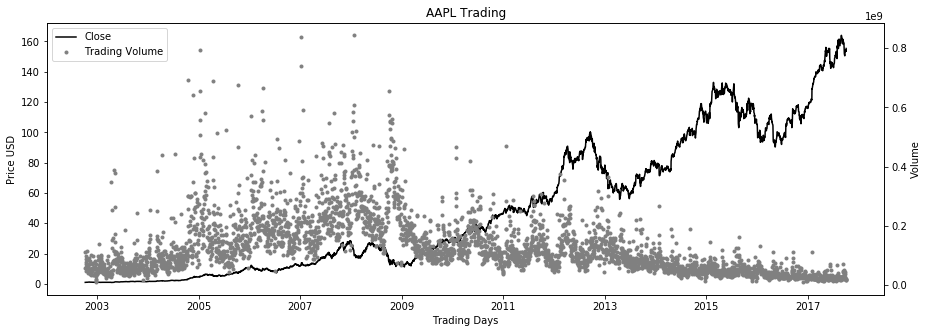

In [4]:
# plot data
fig, ax1 = plt.subplots(figsize=(15, 5))

# axis 1 - close prices vs. trading days
lns1 = ax1.plot(my_stck['index'], my_stck['Close'], 'black', label='Close')
#set x-axis label
ax1.set_xlabel('Trading Days')
# set y-axis label
ax1.set_ylabel('Price USD')

# axis 2 - volume vs. trading days
ax2 = ax1.twinx()
lns2 = ax2.plot(my_stck['index'], my_stck['Volume'], 'r.', color='gray', label='Trading Volume')
# set y-axis label
ax2.set_ylabel('Volume')

# add title
ax1.set_title(my_ticker + ' Trading')

# add legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

plt.show()

In [5]:
# create a new DataFrame with close change price and volume for observation of corelation
new_df = pd.DataFrame()

# time lag parameter in computing the close change price
t_lag = 1

# build the comparison comparison data from stock data
close_ys = my_stck['Close'][:-t_lag].reset_index()
close_td = my_stck['Close'][t_lag:].reset_index()
volume_td = my_stck['Volume'][t_lag:].reset_index()

# add factors to dataframe
new_df['Close_prcnt'] = (close_td['Close']-close_ys['Close'])/close_ys['Close']
new_df['Volume'] = volume_td['Volume']

print(new_df.head())

   Close_prcnt     Volume
0    -0.005998  111102600
1    -0.006444   88271400
2     0.038192   78624000
3     0.027665   70177800
4     0.017947   46706800


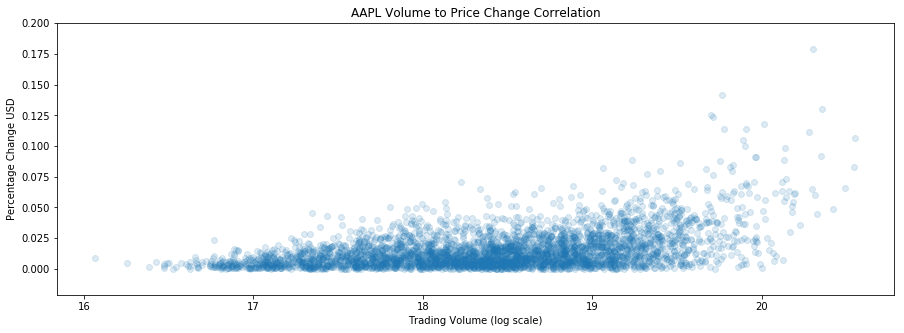

In [6]:
# scale the volume data with log
plot_vol = np.log(new_df['Volume'])
# absolute value of the close price change
plot_prcnt = np.abs(new_df['Close_prcnt'])

# plot Volume to Value Delta 
fig, ax = plt.subplots(figsize=(15, 5))
# axis 1 - adjusted Close
ax.scatter(plot_vol, plot_prcnt, alpha=0.15)

# set x-axis label
ax.set_xlabel('Trading Volume (log scale)')
# set y-axis label
ax.set_ylabel('Percentage Change USD')

# add title
ax.set_title(my_ticker + ' Volume to Price Change Correlation')

plt.show()

In [7]:
# fix random seed for reproducibility
np.random.seed(7)

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.metrics import mean_squared_error

Using TensorFlow backend.


In [8]:
# extract the two 'Close' and 'Date' columns for our studeis
my_stck_close = my_stck.as_matrix(columns=[my_stck.columns[-2]])

In [9]:
def perpare_dataset(data, look_back=1, prcnt_split=0.7, normalize=True):
    '''
    cmt
    cmt
    cmt
    '''
    
    # find the index for splittig the data to training and test
    index_split = round(prcnt_split*len(data))
    
    # initialize the input training and test lists
    x_train_list = []
    x_test_list = []
    
    # build the training and test input lists based on the lookback parameter
    for i in range(look_back):
        x_train_list.append(data[i:index_split-look_back+1+i])
        x_test_list.append(data[index_split+i:len(data)-look_back+i])
        
    # do the same for output training and test data lists
    y_train_list = data[look_back:index_split+1]
    y_test_list = data[index_split+look_back:]
    
    # scale data
    scale_data = {}   
    # NORMALIZATION if needed...
    if normalize:
        
        scale_x_train = []
        scale_x_test = []
        
        for i in range(look_back):
            
            # assess the minimum and maximum for each column of input
            min_train, max_train = min(x_train_list[i]), max(x_train_list[i])
            min_test, max_test = min(x_test_list[i]), max(x_test_list[i])
            
            # store the values for future use -> scale back to USD price
            scale_x_train.append([min_train, max_train])
            scale_x_test.append([min_test, max_test])
            
            # perform the scaling on each column/feature
            x_train_list[i] = (x_train_list[i]-min_train)/(max_train-min_train)
            x_test_list[i] = (x_test_list[i]-min_test)/(max_test-min_test)
        
        # same for output data (see above)
        scale_y_train = [min(y_train_list), max(y_train_list)]
        scale_y_test = [min(y_test_list), max(y_test_list)]
        
        # same for output data (see above)
        y_train_list = (y_train_list-min(y_train_list))/(max(y_train_list)-min(y_train_list))
        y_test_list = (y_test_list-min(y_test_list))/(max(y_test_list)-min(y_test_list))
        
        # scale data
        scale_data['x_train'] = scale_x_train
        scale_data['y_train'] = scale_y_train
        scale_data['x_test'] = scale_x_test
        scale_data['y_test'] = scale_y_test
    
    # change the format of all lists to numpy arrays
    x_train = np.array(x_train_list).transpose(1,0,2)
    y_train = np.array(y_train_list)
    x_test = np.array(x_test_list).transpose(1,0,2)
    y_test = np.array(y_test_list)
    
    # return the prepared arrays and dictionary
    return x_train, y_train, x_test, y_test, scale_data

In [10]:
# split the dataset and prepare them for Keras
look_back = 1
prcnt_split = 0.7
normalize = True
x_train, y_train, x_test, y_test, scale_data = perpare_dataset(my_stck_close, look_back, prcnt_split, normalize)

In [11]:
# create Keras Model
# set up hyperparameters
my_batch_size = 1
my_epochs = 1 # 200
n_nodes = 256

# create the LSTM model
model = Sequential()
model.add(LSTM(n_nodes, batch_input_shape=(my_batch_size, look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

# compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compiling time = ' + str(time.time() - start))

compiling time = 0.0328061580657959


In [12]:
# Train the model
model.fit(x_train, 
          y_train,
          epochs=my_epochs, 
          batch_size=my_batch_size,
          verbose=2)

Epoch 1/1
13s - loss: 0.0032


In [13]:
# generate predictions for training
y_predict = model.predict(x_test, batch_size=my_batch_size)

#
if normalize:
    sc_min, sc_max = scale_data['y_test'][0][0], scale_data['y_test'][1][0]

#
    y_predict = y_predict*(sc_max - sc_min) + sc_min
    y_test = y_test*(sc_max - sc_min) + sc_min

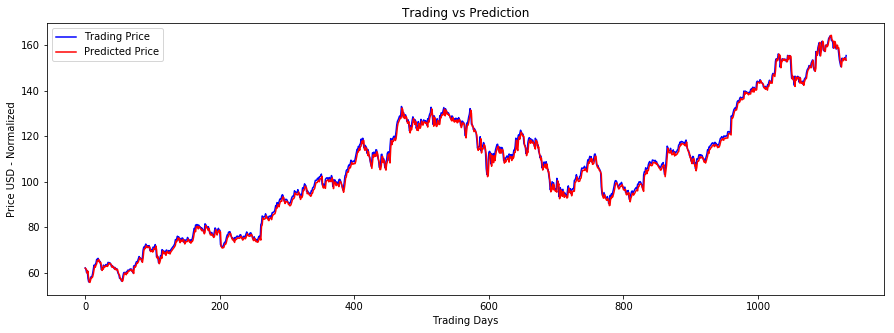

In [14]:
#plot the trading vs predictions

# set up plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)

# add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')

# plot actual and predicted close values
plt.plot(y_test, 'blue', label='Trading Price')
plt.plot(y_predict, 'red', label='Predicted Price')

# set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [15]:
# The mean squared error
testScore = model.evaluate(x_test, y_test, batch_size=my_batch_size, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 11855.003207 MSE (108.880683 RMSE)


In [16]:
print(y_test[-2:])
print(y_predict[-2:])

[[ 153.48]
 [ 155.39]]
[[ 154.36695862]
 [ 153.33547974]]
